In [ ]:
import os
import zipfile
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
from urllib.request import urlretrieve
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
class DLProgress(tqdm):
    """
    Handle Progress Bar while Downloading
    """
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection and
        once after each block read thereafter.
        :param block_num: A count of blocks transferred so far
        :param block_size: Block size in bytes
        :param total_size: The total size of the file. This may be -1 on older FTP servers which do not return
                            a file size in response to a retrieval request.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

os.mkdir("data")
url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip'
save_path = "dataset.zip"

with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading {}'.format("Celeb A Dataset")) as pbar:
  urlretrieve(url, save_path, pbar.hook)

with zipfile.ZipFile("dataset.zip", "r") as file:
  file.extractall("./data")

In [ ]:
imaGen = ImageDataGenerator(preprocessing_function=lambda x: x / 255)

x_real = imaGen.flow_from_directory(directory="data",
                                    target_size=(64, 64),
                                    shuffle=True,
                                    class_mode=None)

Found 202599 images belonging to 1 classes.


In [ ]:
generator = Sequential()

generator.add(layers.Input(shape=(128,)))
generator.add(layers.Dense(4*4*128))
generator.add(layers.Reshape((4, 4, 128)))
generator.add(layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding="same"))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding="same"))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Conv2DTranspose(filters=256, kernel_size=4, strides=2, padding="same"))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Conv2DTranspose(filters=512, kernel_size=4, strides=2, padding="same"))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Conv2D(filters=3, kernel_size=5, padding="same", activation="sigmoid"))

generator.compile(optimizer=Adam(0.001, 0.5), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
descriminator = Sequential()

descriminator.add(layers.Input(shape=(64, 64, 3)))
descriminator.add(layers.Conv2D(filters=64, kernel_size=4, strides=2, padding="same"))
descriminator.add(layers.LeakyReLU(0.2))
descriminator.add(layers.Conv2D(filters=128, kernel_size=4, strides=2, padding="same"))
descriminator.add(layers.LeakyReLU(0.2))
descriminator.add(layers.Conv2D(filters=128, kernel_size=4, strides=2, padding="same"))
descriminator.add(layers.LeakyReLU(0.2))
descriminator.add(layers.Flatten())
descriminator.add(layers.Dropout(0.2))
descriminator.add(layers.Dense(1, activation="sigmoid"))

descriminator.compile(optimizer=Adam(0.001, 0.5), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
descriminator.trainable = False

gan_input = layers.Input(shape=(128,))
gene = generator(gan_input)
gan_output = descriminator(gene)

gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(optimizer=Adam(0.001, 0.5), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
batch_size = 32
epochs = 500

for e in tqdm(range(epochs)):
  x_real.reset()
  for i in range(1):
    z = np.random.normal(size=(batch_size, 128))
    x_fake = generator.predict(z, verbose=0)

    sample = np.random.choice(range(2*batch_size), 2*batch_size, replace=False)

    fake_real = np.concatenate([x_fake, next(x_real)])

    labels = np.zeros(2*batch_size)
    labels[batch_size:] += 0.9

    descriminator.trainable = True
    descriminator.train_on_batch(fake_real[sample], y=labels[sample], reset_metrics=False)

    descriminator.trainable = False
    noise = np.random.normal(size=(batch_size, 128))
    y_fake = np.ones(batch_size)

    gan.train_on_batch(noise, y=y_fake, reset_metrics=False)

100%|██████████| 500/500 [03:29<00:00,  2.38it/s]


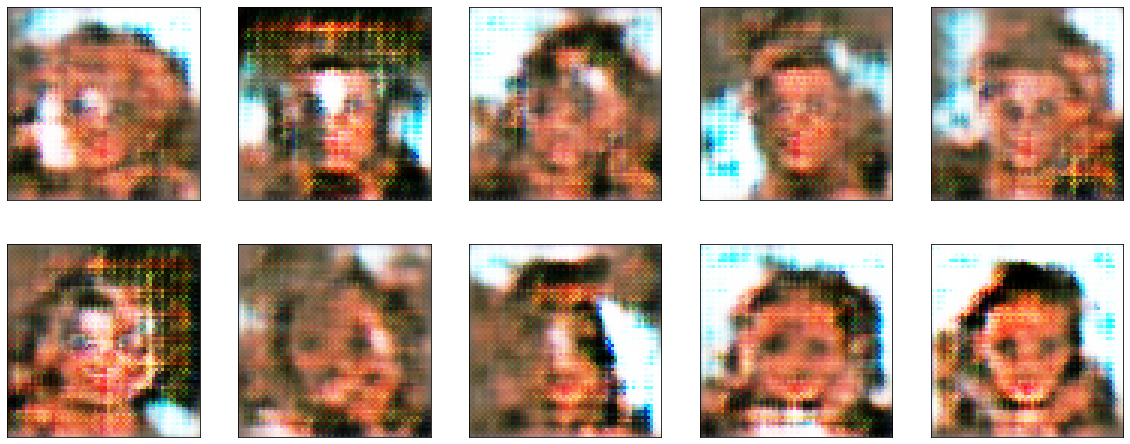

In [ ]:
z = np.random.normal(0, 1, size=(10, 128))
imgs = generator.predict(z, verbose=0)

fig = plt.figure(figsize=(20, 8))
for i in range(10):
  ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
  ax.imshow(imgs[i])